In [125]:
import numpy as np
import pandas as pd
from numpy import interp
from matplotlib import pyplot as plt

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

In [130]:
from sklearn.metrics import plot_confusion_matrix, roc_auc_score,  auc, \
    precision_recall_fscore_support, classification_report, roc_curve, plot_roc_curve

In [5]:
from sklearn import set_config
set_config(display='diagram')   

In [95]:
from catboost import CatBoostClassifier

In [111]:

from itertools import cycle
from time import time

# Import data

In [6]:
df_train = pd.read_csv('./data/train.csv')

In [7]:
df_test = pd.read_csv('./data/test.csv')

In [8]:
sample_sub = pd.read_csv('./data/sample_submission.csv')

In [9]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S
99998,99998,0,3,"Caughlin, Thomas",male,51.00,0,1,458654,30.92,NaN,S


In [10]:
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
1,100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
2,100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
3,100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
4,100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C
...,...,...,...,...,...,...,...,...,...,...,...
99995,199995,3,"Cash, Cheryle",female,27.0,0,0,7686,10.12,NaN,Q
99996,199996,1,"Brown, Howard",male,59.0,1,0,13004,68.31,NaN,S
99997,199997,3,"Lightfoot, Cameron",male,47.0,0,0,4383317,10.87,NaN,S
99998,199998,1,"Jacobsen, Margaret",female,49.0,1,2,PC 26988,29.68,B20828,C


In [11]:
sample_sub

,PassengerId,Survived
0,100000,1
1,100001,1
2,100002,1
3,100003,1
4,100004,1
...,...,...
99995,199995,1
99996,199996,1
99997,199997,1
99998,199998,1


## Basic preprocess

In [12]:
X_train = df_train[[col for col in df_train.columns if col != 'Survived']]
X_train.columns = [c.lower() for c in X_train.columns]
X_train.set_index('passengerid', inplace=True)
X_train.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,
0,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [13]:
y_train = df_train[['PassengerId','Survived']]
y_train.columns = [c.lower() for c in y_train.columns]
y_train.set_index('passengerid', inplace=True)
y_train = y_train['survived']
y_train.head()

passengerid
0    1
1    0
2    0
3    0
4    1
Name: survived, dtype: int64

In [14]:
X_test = df_test[[col for col in df_test.columns if col != 'Survived']]
X_test.columns = [c.lower() for c in X_test.columns]
X_test.set_index('passengerid', inplace=True)
X_test.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,
100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


## pipeline simple

In [15]:
text_features = ['name', 'ticket']
cat_features = ['sex', 'embarked', 'cabin']

In [16]:
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [17]:
original_features = X_train.columns.to_list()

In [18]:
def transform_name(df_base, col):
    df = df_base[col].apply(lambda x: x.split(',')).to_frame('list_name')
    df['surname'] = df['list_name'].apply(lambda x: x[0])
    df['forename'] = df['list_name'].apply(lambda x: x[1])
    return df[['surname', 'forename']]

In [19]:
def get_tck_str(tck):
    try:
        x = tck.split()
        try: 
            a = int(x[0])
            return None
        except:
            return x[0]
    except:
        return None
    
def get_tck_num(tck):
    try:
        x = tck.split()
        try:
            a = int(x[0])
            return a
        except:
            return None
    except:
        return None

def transform_ticket(df_base, col):
    df_ticket = df_base[col].to_frame('ticket')
    df_ticket['ticket_str'] = df_base[col].apply(get_tck_str)
    df_ticket['ticket_num'] = df_base[col].apply(get_tck_num)
    return df_ticket[['ticket_str', 'ticket_num']]

In [20]:
def transform_cabin(df_base, col):
    df_cabin = df_base[col].to_frame('cabin')
    df_cabin_clean = df_cabin[~df_cabin['cabin'].isna()].copy()
    df_cabin_clean['cabin_str'] = df_cabin_clean['cabin'].apply(lambda x: x[0])
    df_cabin_clean['cabin_num'] = df_cabin_clean['cabin'].apply(lambda x: x[1:]).astype(int)
    return df_cabin.join(df_cabin_clean[['cabin_str', 'cabin_num']])[['cabin_str', 'cabin_num']]

In [21]:
from sklearn.base import TransformerMixin, BaseEstimator
class PassNameTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.X = transform_name(X, 'name')
        return self.X

    # I have corrected the output here, See point 2
    def get_feature_names(self):
        return self.X.columns.tolist()

class TicketTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.X = transform_ticket(X, 'ticket')
        return self.X

    # I have corrected the output here, See point 2
    def get_feature_names(self):
        return self.X.columns.tolist()
    
class CabinTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.X = transform_cabin(X, 'cabin')
        return self.X

    # I have corrected the output here, See point 2
    def get_feature_names(self):
        return self.X.columns.tolist()
class ColumnSelectTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        super(ColumnSelectTransformer).__init__()
        self.columns=columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.columns]

In [22]:
def lower_values(df):
    o_features = df.dtypes[df.dtypes=='object'].index.to_list()
    df_copy = df.copy()
    for c in o_features:
        df_copy[c] = df_copy[c].apply(lambda x: x.lower() if type(x)==str else None)
    return df_copy
class LowerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        return lower_values(X)

In [83]:
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector
from tqdm.auto import tqdm

class featureUnion(FeatureUnion):
    def _hstack(self, Xs):
        cols = [X.columns.tolist() for X in Xs]
        dtypes = []
        for X in Xs:
            dtypes.append([str(X[col].dtype) for col in X])
        cols = np.hstack(cols)
        dtypes = np.hstack(dtypes)
        data = pd.DataFrame(super()._hstack(Xs), columns = cols)
        print('====Converting columns types====')
        for col, dtype in tqdm(zip(cols, dtypes)):
            data[col] = data[col].astype(dtype)
        return data

class columnTransformer(ColumnTransformer):
    def _hstack(self, Xs):
        cols = [X.columns.tolist() for X in Xs]
        dtypes = []
        print(cols)
        print([X.shape for X in Xs])
        for X in Xs:
            dtypes.append([str(X[col].dtype) for col in X])
        cols = np.hstack(cols)
        dtypes = np.hstack(dtypes)
        data = pd.DataFrame(super()._hstack(Xs), columns = cols)
        print('====Converting columns types====')
        for col, dtype in tqdm(zip(cols, dtypes)):
            data[col] = data[col].astype(dtype)
        return data

In [84]:
col_processor = featureUnion(transformer_list=[
    ('pass_name', PassNameTransformer()),
    ('ticket', TicketTransformer()),
    ('cabin', CabinTransformer()),
    ('others', ColumnSelectTransformer(columns=[c for c in original_features if c not in ('name', 'ticket', 'cabin')]))
]
)
pl = Pipeline(steps=[
    ('raw_data_processor', col_processor),
    ('lower_text_values', LowerTransformer())
])

In [85]:
pl

Pipeline(steps=[('raw_data_processor',
                 featureUnion(transformer_list=[('pass_name',
                                                 PassNameTransformer()),
                                                ('ticket', TicketTransformer()),
                                                ('cabin', CabinTransformer()),
                                                ('others',
                                                 ColumnSelectTransformer(columns=['pclass',
                                                                                  'sex',
                                                                                  'age',
                                                                                  'sibsp',
                                                                                  'parch',
                                                                                  'fare',
                                                                                  'embarked']))])),
                ('lower_text_values', LowerTransformer())])

In [86]:
df2 = pl.fit_transform(X_train)

====Converting columns types====


0it [00:00, ?it/s]

In [87]:
df2

,surname,forename,ticket_str,ticket_num,cabin_str,cabin_num,pclass,sex,age,sibsp,parch,fare,embarked
0,oconnor,frankie,None,209245.0,c,12239.0,1,male,NaN,2,0,27.14,s
1,bryan,drew,None,27323.0,None,NaN,3,male,NaN,0,0,13.35,s
2,owens,kenneth,ca,NaN,None,NaN,3,male,0.33,1,2,71.29,s
3,kramer,james,a.,NaN,None,NaN,3,male,19.00,0,0,13.04,s
4,bond,michael,None,427635.0,None,NaN,3,male,25.00,0,0,7.76,s
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,bell,adele,pc,NaN,d,17243.0,2,female,62.00,0,0,14.86,c
99996,brown,herman,None,13273.0,None,NaN,2,male,66.00,0,0,11.15,s
99997,childress,charles,None,NaN,None,NaN,3,male,37.00,0,0,9.95,s
99998,caughlin,thomas,None,458654.0,None,NaN,3,male,51.00,0,1,30.92,s


In [88]:
from sklearn.impute import SimpleImputer

class simpleImputer(SimpleImputer):
    def fit(self, X, y=None):
        self._cols = X.columns.tolist()
        self._dtypes = [str(X[col].dtype) for col in X.columns]
        super().fit(X, y)
        return self
        
    def transform(self, X):
        X_ = super().transform(X)
        data = pd.DataFrame(X_, columns = self._cols)
        for col, dtype in tqdm(zip(self._cols, self._dtypes)):
            data[col] = data[col].astype(dtype)
        return data
        

In [89]:
col_handle_na = columnTransformer(
    transformers=[
        ('text_features', simpleImputer(missing_values=None, strategy='constant', fill_value='unk'), make_column_selector(dtype_include=['object'])),
        ('float_features', simpleImputer(strategy='median'), make_column_selector(dtype_include=['float64'])),
        ('count_features', simpleImputer(strategy='most_frequent'), make_column_selector(dtype_include=['int64']))
    ],
    remainder='passthrough'
)

In [90]:
pl_simple = Pipeline(steps=[
    ('pl', pl),
    ('null_handling', col_handle_na)
])

In [91]:
pl_simple

Pipeline(steps=[('pl',
                 Pipeline(steps=[('raw_data_processor',
                                  featureUnion(transformer_list=[('pass_name',
                                                                  PassNameTransformer()),
                                                                 ('ticket',
                                                                  TicketTransformer()),
                                                                 ('cabin',
                                                                  CabinTransformer()),
                                                                 ('others',
                                                                  ColumnSelectTransformer(columns=['pclass',
                                                                                                   'sex',
                                                                                                   'age',
                                                                                                   'sibsp',
                                                                                                   'parch',
                                                                                                   'fare',
                                                                                                   'embarked']))])),
                                 ('lower_text_values', LowerTransformer())])),
                ('null_handling...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6948f7940>),
                                                 ('float_features',
                                                  simpleImputer(strategy='median'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6948f7520>),
                                                 ('count_features',
                                                  simpleImputer(strategy='most_frequent'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6948f7a60>)]))])

In [92]:
df3 = pl_simple.fit_transform(X_train)

====Converting columns types====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'], ['ticket_num', 'cabin_num', 'age', 'fare'], ['pclass', 'sibsp', 'parch']]
[(100000, 6), (100000, 4), (100000, 3)]
====Converting columns types====


0it [00:00, ?it/s]

In [93]:
df3

,surname,forename,ticket_str,cabin_str,sex,embarked,ticket_num,cabin_num,age,fare,pclass,sibsp,parch
0,oconnor,frankie,unk,c,male,s,209245.0,12239.0,39.00,27.14,1,2,0
1,bryan,drew,unk,unk,male,s,27323.0,12603.5,39.00,13.35,3,0,0
2,owens,kenneth,ca,unk,male,s,39185.5,12603.5,0.33,71.29,3,1,2
3,kramer,james,a.,unk,male,s,39185.5,12603.5,19.00,13.04,3,0,0
4,bond,michael,unk,unk,male,s,427635.0,12603.5,25.00,7.76,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,bell,adele,pc,d,female,c,39185.5,17243.0,62.00,14.86,2,0,0
99996,brown,herman,unk,unk,male,s,13273.0,12603.5,66.00,11.15,2,0,0
99997,childress,charles,unk,unk,male,s,39185.5,12603.5,37.00,9.95,3,0,0
99998,caughlin,thomas,unk,unk,male,s,458654.0,12603.5,51.00,30.92,3,0,1


In [104]:
class PipelineLogger(object):
    def __init__(self):
        pass
        
    def log_start(self):
        self.start_time = time()
        print(f'======== {self.__class__.__name__} - START ========')
        return None
        
    def log_finish(self):
        self.duration = time() - self.start_time
        print(f'======== {self.__class__.__name__} - FINISH =======> Take: {self.duration:.6f}(s)')


class ExperimentBase(BaseEstimator):
    def evaluate(self, X_test, y_test):
        print('Evaluating model')
        print(classification_report(y_true=y_test, y_pred=self.predict(X_test)))
        metrics = self.auc_report(X_test, y_test)
        metrics['precision'], metrics['recall'], metrics['f1_score'], metrics['support'] = precision_recall_fscore_support(y_test, self.predict(X_test))
        return metrics
    
    def auc_report(self, X, y_true):
        classes = self.classes_
        y_pred_classes = self.predict_proba(X)
        n_classes = len(classes)

        lw = 2
        for i in range(len(classes)):
            print(f"""{classes[i]}: {roc_auc_score(y_true=(y_true==classes[i]).astype(int), y_score=y_pred_classes[:,i])}""")

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true=(y_true==classes[i]).astype(int), y_score=y_pred_classes[:,i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(classes)):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure()

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(classes[i], roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        plt.show()
        metrics = {
            'macro_auc': roc_auc["macro"]
        }
        for i in range(n_classes):
            metrics[f'auc_{classes[i]}'] = roc_auc[i]
        return metrics


In [120]:
class CustomCatBoostClassifier(CatBoostClassifier, ExperimentBase, PipelineLogger):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def fit(self, X, y, self_evaluate=True, **kwargs):
        self.log_start()
        if self._init_params.get('cat_features') is not None:
            cat_features_ = [c for c in self._init_params['cat_features'] if c in X.columns]
            self._init_params['cat_features'] = cat_features_
        else:
            cat_features_ = None
        if self._init_params.get('text_features') is not None:
            text_features_ = [c for c in self._init_params['text_features'] if c in X.columns]
            self._init_params['text_features'] = text_features_
        else:
            text_features_ = None
        
        X_t, X_e, y_t, y_e = self.train_eval_split(X, y, cat_features_, text_features_)
        super().fit(X_t, y_t, eval_set=(X_e, y_e), cat_features=cat_features_, text_features=text_features_)
        if self_evaluate:
            _ = self.evaluate(X_e, y_e)
        self.log_finish()
        return self
        
    def train_eval_split(self, X, y, cat_features_, text_features_, eval_frac=0.1, add_na_Xy=False, na_label=0):
        X_e = X.sample(frac=eval_frac, random_state=42)
        y_e = y.loc[X_e.index]
        X_t = X.drop(X_e.index)
        y_t = y.loc[X_t.index]
        if add_na_Xy:
            X_t = pd.concat([X_t, pd.DataFrame([[np.nan] * X_t.shape[1]], columns=X_t.columns)], ignore_index=True)
            y_t = pd.concat([y_t, pd.Series([na_label])], ignore_index=True)
        if cat_features_ is not None:
            cat_features_ = [c for c in cat_features_ if c in X.columns]
            X_t[cat_features_] = X_t[cat_features_].fillna('unk')
            X_e[cat_features_] = X_e[cat_features_].fillna('unk')
        if text_features_ is not None:
            text_features_ = [c for c in text_features_ if c in X.columns]
            X_t[text_features_] = X_t[text_features_].fillna('unk')
            X_e[text_features_] = X_e[text_features_].fillna('unk')
        
        return X_t, X_e, y_t, y_e


In [121]:
df3.head(2)

,surname,forename,ticket_str,cabin_str,sex,embarked,ticket_num,cabin_num,age,fare,pclass,sibsp,parch
0,oconnor,frankie,unk,c,male,s,209245.0,12239.0,39.0,27.14,1,2,0
1,bryan,drew,unk,unk,male,s,27323.0,12603.5,39.0,13.35,3,0,0


In [122]:
cat_features = ['ticket_str', 'cabin_str', 'embarked', 'sex'] + ['surname', 'forename']
# text_features = 
cb_cfg = {
    'iterations': 1000,
    'task_type': 'CPU',
    'cat_features': cat_features,
#     'text_features': text_features,
    'use_best_model': True,
    'early_stopping_rounds':50,
    'verbose': True,
    'metric_period': 25
}

In [123]:
pl4 = Pipeline(steps=[
    ('pl_simple', pl_simple),
    ('catboost_simple', CustomCatBoostClassifier(**cb_cfg))
])
pl4

Pipeline(steps=[('pl_simple',
                 Pipeline(steps=[('pl',
                                  Pipeline(steps=[('raw_data_processor',
                                                   featureUnion(transformer_list=[('pass_name',
                                                                                   PassNameTransformer()),
                                                                                  ('ticket',
                                                                                   TicketTransformer()),
                                                                                  ('cabin',
                                                                                   CabinTransformer()),
                                                                                  ('others',
                                                                                   ColumnSelectTransformer(columns=['pclass',
                                                                                                                    'sex',
                                                                                                                    'age',
                                                                                                                    'sibsp',
                                                                                                                    'parch',
                                                                                                                    'fare',
                                                                                                                    'embarked']))])),
                                                  ('lower_text_values',
                                                   LowerTran...
                                                                   simpleImputer(strategy='most_frequent'),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6948f7a60>)]))])),
                ('catboost_simple',
                 CustomCatBoostClassifier(cat_features=['ticket_str',
                                                        'cabin_str', 'embarked',
                                                        'sex', 'surname',
                                                        'forename'],
                                          early_stopping_rounds=50,
                                          iterations=1000, metric_period=25,
                                          task_type='CPU', use_best_model=True,
                                          verbose=True))])

====Converting columns types====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'], ['ticket_num', 'cabin_num', 'age', 'fare'], ['pclass', 'sibsp', 'parch']]
[(100000, 6), (100000, 4), (100000, 3)]
====Converting columns types====


0it [00:00, ?it/s]

======== CustomCatBoostClassifier - START ========
Learning rate set to 0.096296
0:	learn: 0.6509106	test: 0.6500870	best: 0.6500870 (0)	total: 36.9ms	remaining: 36.9s


25:	learn: 0.4771816	test: 0.4732935	best: 0.4732935 (25)	total: 750ms	remaining: 28.1s
50:	learn: 0.4697525	test: 0.4668533	best: 0.4668533 (50)	total: 1.64s	remaining: 30.4s
75:	learn: 0.4667908	test: 0.4652342	best: 0.4652342 (75)	total: 2.49s	remaining: 30.3s
100:	learn: 0.4649027	test: 0.4643844	best: 0.4643844 (100)	total: 3.25s	remaining: 29s
125:	learn: 0.4630746	test: 0.4636356	best: 0.4636172 (124)	total: 4s	remaining: 27.8s
150:	learn: 0.4609647	test: 0.4626024	best: 0.4626024 (150)	total: 4.8s	remaining: 27s
175:	learn: 0.4595652	test: 0.4623817	best: 0.4623743 (174)	total: 5.59s	remaining: 26.2s
200:	learn: 0.4583941	test: 0.4622576	best: 0.4622420 (199)	total: 6.37s	remaining: 25.3s
225:	learn: 0.4571629	test: 0.4620526	best: 0.4620526 (225)	total: 7.17s	remaining: 24.6s
250:	learn: 0.4560363	test: 0.4619599	best: 0.4619213 (241)	total: 7.98s	remaining: 23.8s
275:	learn: 0.4547426	test: 0.4618220	best: 0.4617892 (274)	total: 8.79s	remaining: 23.1s
300:	learn: 0.4536035	te

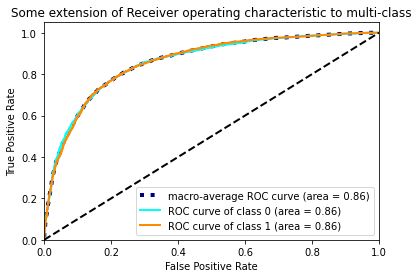

======== CustomCatBoostClassifier - FINISH =======> Take: 12.463147(s)


Pipeline(steps=[('pl_simple',
                 Pipeline(steps=[('pl',
                                  Pipeline(steps=[('raw_data_processor',
                                                   featureUnion(transformer_list=[('pass_name',
                                                                                   PassNameTransformer()),
                                                                                  ('ticket',
                                                                                   TicketTransformer()),
                                                                                  ('cabin',
                                                                                   CabinTransformer()),
                                                                                  ('others',
                                                                                   ColumnSelectTransformer(columns=['pclass',
                                                                                                                    'sex',
                                                                                                                    'age',
                                                                                                                    'sibsp',
                                                                                                                    'parch',
                                                                                                                    'fare',
                                                                                                                    'embarked']))])),
                                                  ('lower_text_values',
                                                   LowerTran...
                                                                   simpleImputer(strategy='most_frequent'),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6948f7a60>)]))])),
                ('catboost_simple',
                 CustomCatBoostClassifier(cat_features=['ticket_str',
                                                        'cabin_str', 'embarked',
                                                        'sex', 'surname',
                                                        'forename'],
                                          early_stopping_rounds=50,
                                          iterations=1000, metric_period=25,
                                          task_type='CPU', use_best_model=True,
                                          verbose=True))])

In [131]:
pl4.fit(X_train, y_train)

In [178]:
from catboost import CatBoostRegressor, CatBoostClassifier

In [180]:
def fill_unk(sr):
    return sr.fillna('unk')

In [181]:
def fill_mean(sr):
    return sr.fillna(sr.mean())

In [182]:
def fill_0(sr):
    return sr.fillna(0)

In [183]:
def fill_popular(sr):
    popular = sr.value_counts().index[0]
    return sr.fillna(popular)

In [184]:
((df2['ticket_str'].value_counts().max() / df2['ticket_str'].value_counts()) ** 0.3).to_dict()

{'pc': 1.0,
 'a.': 1.172558924272542,
 'c.a.': 1.4930070292670683,
 'ston/o': 1.5398503617138108,
 'sc/paris': 1.546324951420759,
 'a/5': 1.7613713129371242,
 'soton/o.q.': 1.9118677832994102,
 'w./c.': 1.9544197633354434,
 'a/5.': 1.97821233213953,
 'pp': 2.010050373472857,
 'f.c.c.': 2.055849472309812,
 'sc/ah': 2.1149313053493453,
 'ca.': 2.156525142682023,
 'ston/o2.': 2.2678590415219233,
 'a/4': 2.317558829652617,
 's.o.c.': 2.4891674024289627,
 'f.c.': 2.511635098481276,
 'soton/o2': 2.5271129738488165,
 's.c./paris': 2.5350088959312904,
 'ca': 2.5538574204092668,
 'soton/oq': 2.6203790569660126,
 'c': 2.7454734768560662,
 'we/p': 2.9405775829198197,
 'w.e.p.': 2.9715158105213897,
 'sc': 2.9984092038990555,
 'p/pp': 3.0859449625553044,
 's.o./p.p.': 3.1857567885616125,
 'a/4.': 3.2374490358210317,
 'a./5.': 3.4178444779790533,
 'sco/w': 3.467748915615144,
 'a.5.': 3.776591219251863,
 'aq/4': 3.8224974000984213,
 'lp': 4.138925875399039,
 'fa': 4.184330006248806,
 'a/s': 4.4494697

In [185]:
((df2['cabin_str'].value_counts().max() / df2['cabin_str'].value_counts()) ** 0.3).to_dict()

{'c': 1.0,
 'b': 1.1491744912926358,
 'a': 1.2075176724525294,
 'd': 1.4243520812700914,
 'e': 1.774203378786344,
 'f': 2.373483879107566,
 'g': 2.611717706060768,
 't': 5.892442473806596}

In [186]:
impute_plan = {
    'features_plan': {
        'fare': {
            'model': CatBoostRegressor,
            'predictors': [c for c in df2.columns if c not in ['fare']],
            'catboost_kwgs': {'iterations':200}
        },
        'embarked': {
            'model': CatBoostClassifier,
            'predictors': [c for c in df2.columns if c not in ['embarked']],
            'catboost_kwgs': {'iterations': 200}
        },
        'age': {
            'model': CatBoostRegressor,
            'predictors': [c for c in df2.columns if c not in ['age']],
            'catboost_kwgs': {'iterations': 200}
        },
        'ticket_num':{
            'model': CatBoostRegressor,
            'predictors': [c for c in df2.columns if c not in ['age']],
            'catboost_kwgs': {'iterations': 200}
        },
        'ticket_str':{
            'model': CatBoostClassifier,
            'predictors': [c for c in df2.columns if c not in ['embarked']],
            'catboost_kwgs': {
                'iterations': 200, 
                'class_weights': ((df2['ticket_str'].value_counts().max() / df2['ticket_str'].value_counts()) ** 0.3).to_dict()
            }
        },
        'cabin_num':{
            'model': CatBoostRegressor,
            'predictors': [c for c in df2.columns if c not in ['age']],
            'catboost_kwgs': {
                'iterations': 200
            }
        },
        'cabin_str':{
            'model': CatBoostClassifier,
            'predictors': [c for c in df2.columns if c not in ['embarked']],
            'catboost_kwgs': {
                'iterations': 200,
                'class_weights': ((df2['cabin_str'].value_counts().max() / df2['cabin_str'].value_counts()) ** 0.3).to_dict()
            }
        }
    },
    'if_na': {
        'ticket_str':fill_unk,
        'ticket_num':fill_mean,
        'cabin_str':fill_unk,
        'cabin_num':fill_mean,
        'age':fill_mean,
        'embarked':fill_popular,
        'fare': fill_mean
    },
    'eval_frac': 0.1,
    'cat_features': ['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked']
}

In [193]:
from sklearn.model_selection import train_test_split

class CatBoostImputor(BaseEstimator, TransformerMixin):
    def __init__(self, impute_plan, predictors_order):
        super(CatBoostImputor).__init__()
        self.impute_plan = impute_plan
        self.predictors_order = predictors_order
        
    def fit(self, X, y=None):
        return self
    
    def train_eval_test_split(self, x, y):
        eval_frac = self.impute_plan['eval_frac']
        y_test = y[y.isna()].copy()
        x_test = x[y.isna()].copy()
        x_t = x[~y.isna()].copy()
        y_t = y[~y.isna()].copy()
        x_train, x_eval, y_train, y_eval = train_test_split(x_t, y_t, test_size=eval_frac)
        return x_train, y_train, x_eval, y_eval, x_test, y_test
        
    def transform(self, X):
        self.X = X
        self.X_impute = X.copy()
        for col in self.predictors_order:
            predictor_list = self.impute_plan['features_plan'][col]['predictors']
            cat_features=[c for c in predictor_list if c in self.impute_plan['cat_features']]
            # Prepare data to fit
            print(f'Prepare data to fit, feature: {col}')
            x = self.X_impute[predictor_list].copy()
            y = self.X_impute[col]
            na_cols = [col for col in x.columns if x[col].isna().sum() > 0]
            for c in na_cols:
                x[c] = self.impute_plan['if_na'][c](x[c])
            x_train, y_train, x_eval, y_eval, x_test, y_test = self.train_eval_test_split(x, y)
            
            # Create model
            ModelClass = self.impute_plan['features_plan'][col]['model']
            model = ModelClass(**self.impute_plan['features_plan'][col]['catboost_kwgs'], early_stopping_rounds=50, verbose=True, metric_period=50, use_best_model=True)
            # Fit model
            print(f'Fit model: {col}')
            model.fit(x_train, y_train, eval_set=(x_eval, y_eval), cat_features=cat_features)
            x_test[col] = model.predict(x_test)
            print(f'Predicted for {x_test.shape[0]} unknown examples')
            self.X_impute.loc[y.isna(),col] = x_test[col]
            print(f'Imputed done for {col}')
        print(f'Imputed done for all dataset, num null left: {self.X_impute.isna().sum()}')
        return self.X_impute
            
            

In [194]:
cbi = CatBoostImputor(impute_plan, ['fare', 'embarked', 'age', 'ticket_num', 'ticket_str', 'cabin_num', 'cabin_str'])

In [195]:
clean_X_train = cbi.fit_transform(df2)

Prepare data to fit, feature: fare
Fit model: fare
Learning rate set to 0.293891
0:	learn: 64.5053379	test: 65.2813538	best: 65.2813538 (0)	total: 88ms	remaining: 17.5s


50:	learn: 58.1164228	test: 59.6645429	best: 59.5976580 (28)	total: 1.27s	remaining: 3.71s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 59.59765804
bestIteration = 28

Shrink model to first 29 iterations.
Predicted for 134 unknown examples
Imputed done for fare
Prepare data to fit, feature: embarked
Fit model: embarked
Learning rate set to 0.218473
0:	learn: 0.9044275	test: 0.9016313	best: 0.9016313 (0)	total: 64.1ms	remaining: 12.8s


50:	learn: 0.5328049	test: 0.5391724	best: 0.5391198 (49)	total: 2.88s	remaining: 8.41s
100:	learn: 0.5231827	test: 0.5360037	best: 0.5358740 (98)	total: 5.73s	remaining: 5.62s
150:	learn: 0.5168562	test: 0.5354629	best: 0.5354290 (137)	total: 8.59s	remaining: 2.79s
199:	learn: 0.5115511	test: 0.5356407	best: 0.5352555 (155)	total: 11.4s	remaining: 0us

bestTest = 0.5352554741
bestIteration = 155

Shrink model to first 156 iterations.
Predicted for 250 unknown examples
Imputed done for embarked
Prepare data to fit, feature: age
Fit model: age
Learning rate set to 0.292112
0:	learn: 17.5157367	test: 17.6823815	best: 17.6823815 (0)	total: 21.9ms	remaining: 4.36s


50:	learn: 16.3024382	test: 16.5271066	best: 16.5271066 (50)	total: 1.05s	remaining: 3.07s
100:	learn: 16.2138385	test: 16.5304022	best: 16.5219397 (53)	total: 2.12s	remaining: 2.08s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 16.5219397
bestIteration = 53

Shrink model to first 54 iterations.
Predicted for 3292 unknown examples
Imputed done for age
Prepare data to fit, feature: ticket_num
Fit model: ticket_num
Learning rate set to 0.275335
0:	learn: 603737.2837122	test: 602450.0999171	best: 602450.0999171 (0)	total: 11.2ms	remaining: 2.24s


50:	learn: 68047.4945735	test: 76904.4360531	best: 76889.3946120 (47)	total: 774ms	remaining: 2.26s
100:	learn: 61673.8819338	test: 76625.3194177	best: 75638.2443259 (81)	total: 1.5s	remaining: 1.47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 75638.24433
bestIteration = 81

Shrink model to first 82 iterations.
Predicted for 29278 unknown examples
Imputed done for ticket_num
Prepare data to fit, feature: ticket_str
Fit model: ticket_str
Learning rate set to 0.21245


0:	learn: 1.9879277	test: 1.9607293	best: 1.9607293 (0)	total: 2.59s	remaining: 8m 35s
50:	learn: 0.0890570	test: 0.0617301	best: 0.0617301 (50)	total: 2m 51s	remaining: 8m 20s
100:	learn: 0.0485269	test: 0.0380903	best: 0.0380903 (100)	total: 5m 59s	remaining: 5m 52s
150:	learn: 0.0340204	test: 0.0309974	best: 0.0309828 (148)	total: 10m 35s	remaining: 3m 26s
199:	learn: 0.0225671	test: 0.0221787	best: 0.0221787 (199)	total: 13m 54s	remaining: 0us

bestTest = 0.02217874319
bestIteration = 199

Predicted for 75345 unknown examples
Imputed done for ticket_str
Prepare data to fit, feature: cabin_num
Fit model: cabin_num
Learning rate set to 0.237199
0:	learn: 4464.5314907	test: 4501.8020724	best: 4501.8020724 (0)	total: 12.1ms	remaining: 2.42s


50:	learn: 115.6330019	test: 113.3262921	best: 113.3262921 (50)	total: 547ms	remaining: 1.6s
100:	learn: 66.0572088	test: 64.8792807	best: 64.8792807 (100)	total: 1.07s	remaining: 1.05s
150:	learn: 48.7249357	test: 49.4762709	best: 49.4762709 (150)	total: 1.61s	remaining: 522ms
199:	learn: 40.6397549	test: 42.9492393	best: 42.9492393 (199)	total: 2.14s	remaining: 0us

bestTest = 42.94923931
bestIteration = 199

Predicted for 67866 unknown examples
Imputed done for cabin_num
Prepare data to fit, feature: cabin_str
Fit model: cabin_str
Learning rate set to 0.213579
0:	learn: 0.8373571	test: 0.8325027	best: 0.8325027 (0)	total: 82.7ms	remaining: 16.5s


50:	learn: 0.0018504	test: 0.0014943	best: 0.0014943 (50)	total: 4.76s	remaining: 13.9s
100:	learn: 0.0008366	test: 0.0006821	best: 0.0006821 (100)	total: 10.2s	remaining: 10s
150:	learn: 0.0004781	test: 0.0003835	best: 0.0003835 (150)	total: 15.6s	remaining: 5.06s
199:	learn: 0.0003565	test: 0.0002835	best: 0.0002835 (199)	total: 20.9s	remaining: 0us

bestTest = 0.0002835246949
bestIteration = 199

Predicted for 67866 unknown examples
Imputed done for cabin_str
Imputed done for all dataset, num null left: surname       0
forename      0
ticket_str    0
ticket_num    0
cabin_str     0
cabin_num     0
pclass        0
sex           0
age           0
sibsp         0
parch         0
fare          0
embarked      0
dtype: int64


In [197]:
print('Done')

Done


In [199]:
clean_X_train.to_parquet('data/clean_X_train.parquet')

In [200]:
y_train

passengerid
0        1
1        0
2        0
3        0
4        1
        ..
99995    1
99996    0
99997    0
99998    0
99999    0
Name: survived, Length: 100000, dtype: int64

In [201]:
X_train_t, X_train_e, y_train_t, y_train_e = train_test_split(clean_X_train, y_train, test_size=0.1)

In [206]:
model_clean = CatBoostClassifier(iterations=1000, cat_features=['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'], 
                                 early_stopping_rounds=50, verbose=True, metric_period=50, use_best_model=True)

In [207]:
X_train_t

,surname,forename,ticket_str,ticket_num,cabin_str,cabin_num,pclass,sex,age,sibsp,parch,fare,embarked
59872,pack,david,so/c,23076.000000,t,12608.569663,2,male,42.000000,1,0,26.88,s
60840,collins,nicholas,a/4.,345219.830178,t,12628.409568,3,male,21.000000,0,1,11.71,s
36729,wells,dona,w/c,345462.414166,t,12633.931824,3,female,10.000000,0,1,30.15,s
84527,miller,bertha,a4.,344804.385730,t,12636.923088,3,female,35.000000,3,1,10.92,s
2123,shepard,timothy,lp,462771.000000,t,12628.359445,3,male,40.163735,0,0,28.22,q
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76022,mangone,jeanne,lp,440975.000000,t,12636.329947,3,female,56.000000,2,0,27.70,s
43439,welsh,danny,a4.,6521.000000,t,12639.334013,3,male,39.000000,0,0,20.77,s
19775,lally,warren,aq/3.,339430.000000,t,12642.303842,3,male,28.000000,0,0,26.12,c
60597,stephens,gerard,so/c,349578.000000,t,12629.297601,3,male,64.000000,0,0,8.31,s


In [208]:
model_clean.fit(X_train_t, y_train_t, eval_set = (X_train_e, y_train_e))

Learning rate set to 0.096296
0:	learn: 0.6502257	test: 0.6498158	best: 0.6498158 (0)	total: 37.2ms	remaining: 37.2s


50:	learn: 0.4692910	test: 0.4671675	best: 0.4671675 (50)	total: 1.6s	remaining: 29.7s
100:	learn: 0.4643221	test: 0.4644934	best: 0.4644934 (100)	total: 3.05s	remaining: 27.2s
150:	learn: 0.4607115	test: 0.4633937	best: 0.4633937 (150)	total: 4.61s	remaining: 25.9s
200:	learn: 0.4578400	test: 0.4628615	best: 0.4628615 (200)	total: 6.16s	remaining: 24.5s
250:	learn: 0.4554710	test: 0.4625749	best: 0.4625749 (250)	total: 7.74s	remaining: 23.1s
300:	learn: 0.4530897	test: 0.4623499	best: 0.4622273 (290)	total: 9.31s	remaining: 21.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4622272735
bestIteration = 290

Shrink model to first 291 iterations.


In [209]:
y_train_e_pred = model_clean.predict(X_train_e)

In [211]:
from sklearn.metrics import classification_report
print(classification_report(y_train_e, model_clean.predict(X_train_e)))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81      5730
           1       0.75      0.75      0.75      4270

    accuracy                           0.79     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.79      0.79      0.79     10000



In [277]:
print(classification_report(y_train_t, model_clean.predict(X_train_t)))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82     51496
           1       0.76      0.74      0.75     38504

    accuracy                           0.79     90000
   macro avg       0.78      0.78      0.78     90000
weighted avg       0.79      0.79      0.79     90000



In [274]:
def ft_imp(model):
    fi = pd.DataFrame({
        'feature':X_train_e.columns,
        'importance': model.feature_importances_
    })

    return fi.sort_values(by='importance',ascending=False).iloc[:50].style.bar()

In [275]:
ft_imp(model_clean)

,feature,importance
7,sex,19.745800
6,pclass,12.694931
12,embarked,11.046209
11,fare,10.689131
4,cabin_str,9.064603
2,ticket_str,8.385086
3,ticket_num,8.071651
10,parch,5.464423
1,forename,3.631622
8,age,3.445775


In [215]:
X_test_2 = pl.fit_transform(X_test)

In [216]:
X_test_2

,surname,forename,ticket_str,ticket_num,cabin_str,cabin_num,pclass,sex,age,sibsp,parch,fare,embarked
0,holliday,daniel,None,24745.0,None,NaN,3,male,19.0,0,0,63.01,s
1,nguyen,lorraine,None,13264.0,None,NaN,3,female,53.0,0,0,5.81,s
2,harris,heather,None,25990.0,b,15315.0,1,female,19.0,0,0,38.91,c
3,larsen,eric,None,314011.0,None,NaN,2,male,25.0,0,0,12.93,s
4,cleary,sarah,None,26203.0,b,22515.0,1,female,17.0,0,2,26.89,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,cash,cheryle,None,7686.0,None,NaN,3,female,27.0,0,0,10.12,q
99996,brown,howard,None,13004.0,None,NaN,1,male,59.0,1,0,68.31,s
99997,lightfoot,cameron,None,4383317.0,None,NaN,3,male,47.0,0,0,10.87,s
99998,jacobsen,margaret,pc,NaN,b,20828.0,1,female,49.0,1,2,29.68,c


In [217]:
cbi_test = CatBoostImputor(impute_plan, ['fare', 'embarked', 'age', 'ticket_num', 'ticket_str', 'cabin_num', 'cabin_str'])

In [219]:
X_test_clean = cbi_test.fit_transform(X_test_2)

Prepare data to fit, feature: fare
Fit model: fare
Learning rate set to 0.293892
0:	learn: 55.1960618	test: 54.5580879	best: 54.5580879 (0)	total: 24.7ms	remaining: 4.92s


50:	learn: 41.3540822	test: 41.1962118	best: 41.1764762 (27)	total: 1.12s	remaining: 3.27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 41.17647616
bestIteration = 27

Shrink model to first 28 iterations.
Predicted for 133 unknown examples
Imputed done for fare
Prepare data to fit, feature: embarked
Fit model: embarked
Learning rate set to 0.218472
0:	learn: 0.9426436	test: 0.9447694	best: 0.9447694 (0)	total: 63.4ms	remaining: 12.6s


50:	learn: 0.6392095	test: 0.6460431	best: 0.6460431 (50)	total: 3.24s	remaining: 9.47s
100:	learn: 0.6272011	test: 0.6385094	best: 0.6385094 (100)	total: 6.28s	remaining: 6.15s
150:	learn: 0.6208266	test: 0.6379173	best: 0.6378678 (145)	total: 9.25s	remaining: 3s
199:	learn: 0.6152800	test: 0.6378156	best: 0.6376895 (172)	total: 12.2s	remaining: 0us

bestTest = 0.6376895416
bestIteration = 172

Shrink model to first 173 iterations.
Predicted for 277 unknown examples
Imputed done for embarked
Prepare data to fit, feature: age
Fit model: age
Learning rate set to 0.292
0:	learn: 13.5499598	test: 13.4412677	best: 13.4412677 (0)	total: 23.6ms	remaining: 4.69s


50:	learn: 12.7506781	test: 12.7258926	best: 12.7258926 (50)	total: 1.16s	remaining: 3.39s
100:	learn: 12.6710294	test: 12.7271103	best: 12.7203700 (63)	total: 2.31s	remaining: 2.27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.72037001
bestIteration = 63

Shrink model to first 64 iterations.
Predicted for 3487 unknown examples
Imputed done for age
Prepare data to fit, feature: ticket_num
Fit model: ticket_num
Learning rate set to 0.274637
0:	learn: 647980.2134931	test: 649289.8825789	best: 649289.8825789 (0)	total: 12.1ms	remaining: 2.41s


50:	learn: 90951.1282258	test: 111530.6461503	best: 111357.5291069 (42)	total: 847ms	remaining: 2.47s
100:	learn: 79332.4440834	test: 107614.3109134	best: 107492.5613399 (81)	total: 1.6s	remaining: 1.57s
150:	learn: 71952.8607402	test: 104695.1450320	best: 104092.7743589 (148)	total: 2.35s	remaining: 761ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 104092.7744
bestIteration = 148

Shrink model to first 149 iterations.
Predicted for 30223 unknown examples
Imputed done for ticket_num
Prepare data to fit, feature: ticket_str
Fit model: ticket_str
Learning rate set to 0.212516


0:	learn: 1.4106173	test: 1.4217845	best: 1.4217845 (0)	total: 2.99s	remaining: 9m 54s
50:	learn: 0.0942101	test: 0.0791814	best: 0.0791814 (50)	total: 3m 3s	remaining: 8m 54s
100:	learn: 0.0514678	test: 0.0576127	best: 0.0576127 (100)	total: 6m 20s	remaining: 6m 13s
150:	learn: 0.0314021	test: 0.0433033	best: 0.0432762 (148)	total: 9m 42s	remaining: 3m 9s
199:	learn: 0.0202853	test: 0.0341659	best: 0.0341602 (198)	total: 12m 52s	remaining: 0us

bestTest = 0.03416016999
bestIteration = 198

Shrink model to first 199 iterations.
Predicted for 74958 unknown examples
Imputed done for ticket_str
Prepare data to fit, feature: cabin_num
Fit model: cabin_num
Learning rate set to 0.232899
0:	learn: 4389.2311809	test: 4403.7092374	best: 4403.7092374 (0)	total: 9.65ms	remaining: 1.92s


50:	learn: 113.6599247	test: 113.3399078	best: 113.3399078 (50)	total: 501ms	remaining: 1.46s
100:	learn: 65.7697572	test: 65.4658316	best: 65.4658316 (100)	total: 983ms	remaining: 964ms
150:	learn: 50.4500249	test: 51.2916424	best: 51.2916424 (150)	total: 1.51s	remaining: 489ms
199:	learn: 41.7370003	test: 43.0201233	best: 43.0201233 (199)	total: 1.96s	remaining: 0us

bestTest = 43.02012326
bestIteration = 199

Predicted for 70831 unknown examples
Imputed done for cabin_num
Prepare data to fit, feature: cabin_str
Fit model: cabin_str
Learning rate set to 0.213166
0:	learn: 0.8359094	test: 0.8349688	best: 0.8349688 (0)	total: 75ms	remaining: 14.9s


50:	learn: 0.0020352	test: 0.0016208	best: 0.0016208 (50)	total: 4.13s	remaining: 12.1s
100:	learn: 0.0008114	test: 0.0006060	best: 0.0006060 (100)	total: 8.5s	remaining: 8.33s
150:	learn: 0.0004941	test: 0.0003617	best: 0.0003617 (150)	total: 13.1s	remaining: 4.25s
199:	learn: 0.0003662	test: 0.0002653	best: 0.0002653 (199)	total: 17.5s	remaining: 0us

bestTest = 0.0002652935074
bestIteration = 199

Predicted for 70831 unknown examples
Imputed done for cabin_str
Imputed done for all dataset, num null left: surname       0
forename      0
ticket_str    0
ticket_num    0
cabin_str     0
cabin_num     0
pclass        0
sex           0
age           0
sibsp         0
parch         0
fare          0
embarked      0
dtype: int64


In [228]:
X_test_clean.to_parquet('data/clean_X_test.parquet')

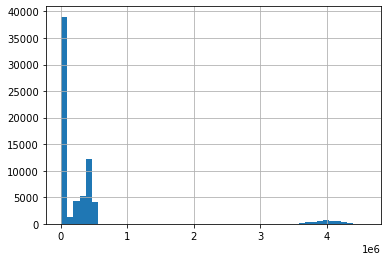

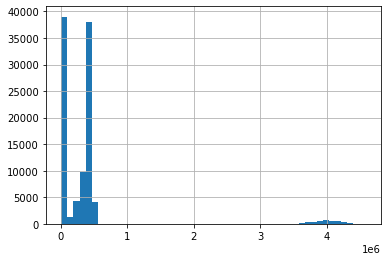

In [234]:
X_test_2.ticket_num.hist(bins=50)
plt.show()
X_test_clean.ticket_num.hist(bins=50)
plt.show()

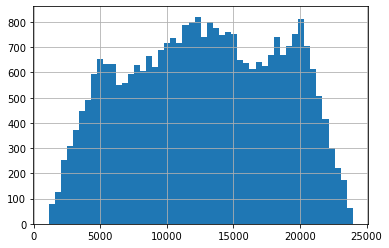

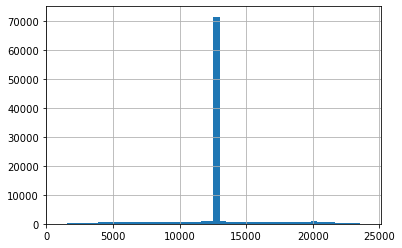

In [235]:
X_test_2.cabin_num.hist(bins=50)
plt.show()
X_test_clean.cabin_num.hist(bins=50)
plt.show()

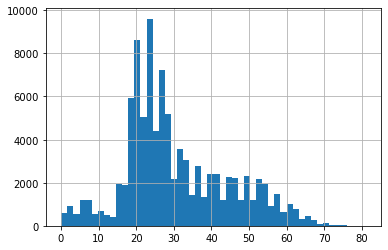

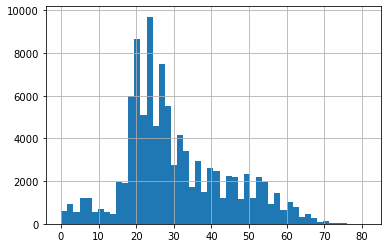

In [238]:
X_test_2.age.hist(bins=50)
plt.show()
X_test_clean.age.hist(bins=50)
plt.show()

In [239]:
X_test_2.cabin_str.value_counts()[:20]

b    8113
a    7212
c    6993
d    2521
f    2323
e    1837
g     144
t      26
Name: cabin_str, dtype: int64

In [240]:
X_test_clean.cabin_str.value_counts()[:20]

t    70262
b     8113
a     7212
c     6993
d     2521
f     2323
e     1837
g      739
Name: cabin_str, dtype: int64

## Extent pipeline

In [284]:
pl

Pipeline(steps=[('raw_data_processor',
                 featureUnion(transformer_list=[('pass_name',
                                                 PassNameTransformer()),
                                                ('ticket', TicketTransformer()),
                                                ('cabin', CabinTransformer()),
                                                ('others',
                                                 ColumnSelectTransformer(columns=['pclass',
                                                                                  'sex',
                                                                                  'age',
                                                                                  'sibsp',
                                                                                  'parch',
                                                                                  'fare',
                                                                                  'embarked']))])),
                ('lower_text_values', LowerTransformer())])

In [289]:
from copy import deepcopy

In [293]:
impute_plan2 = deepcopy(impute_plan)
wgt = 0
impute_plan2['features_plan']['ticket_str']['catboost_kwgs']['class_weights'] = ((df2['ticket_str'].value_counts().max() / df2['ticket_str'].value_counts()) ** wgt).to_dict()
impute_plan2['features_plan']['cabin_str']['catboost_kwgs']['class_weights'] = ((df2['cabin_str'].value_counts().max() / df2['cabin_str'].value_counts()) ** wgt).to_dict()

In [299]:
pl3 = Pipeline(steps = [
    ('aaa', pl), 
    ('catboost_imputor', CatBoostImputor(impute_plan2,  ['fare', 'embarked', 'age', 'ticket_num', 'ticket_str', 'cabin_num', 'cabin_str']))
])

In [300]:
pl3

Pipeline(steps=[('aaa',
                 Pipeline(steps=[('raw_data_processor',
                                  featureUnion(transformer_list=[('pass_name',
                                                                  PassNameTransformer()),
                                                                 ('ticket',
                                                                  TicketTransformer()),
                                                                 ('cabin',
                                                                  CabinTransformer()),
                                                                 ('others',
                                                                  ColumnSelectTransformer(columns=['pclass',
                                                                                                   'sex',
                                                                                                   'age',
                                                                                                   'sibsp',
                                                                                                   'parch',
                                                                                                   'fare',
                                                                                                   'embarked']))])),
                                 ('lower_text_values', LowerTransformer())])),
                ('catboost_imp...
                                                        'cabin_num': <function fill_mean at 0x7fdac8f85940>,
                                                        'cabin_str': <function fill_unk at 0x7fdac8f85700>,
                                                        'embarked': <function fill_popular at 0x7fdac8f858b0>,
                                                        'fare': <function fill_mean at 0x7fdac8f85940>,
                                                        'ticket_num': <function fill_mean at 0x7fdac8f85940>,
                                                        'ticket_str': <function fill_unk at 0x7fdac8f85700>}},
                                 predictors_order=['fare', 'embarked', 'age',
                                                   'ticket_num', 'ticket_str',
                                                   'cabin_num',
                                                   'cabin_str']))])

In [294]:
pl2 = Pipeline(steps=[
    ('raw_data_processor', col_processor),
    ('lower_text_values', LowerTransformer()),
    ('catboost_imputor', CatBoostImputor(impute_plan2,  ['fare', 'embarked', 'age', 'ticket_num', 'ticket_str', 'cabin_num', 'cabin_str']))
])

In [295]:
pl2

Pipeline(steps=[('raw_data_processor',
                 featureUnion(transformer_list=[('pass_name',
                                                 PassNameTransformer()),
                                                ('ticket', TicketTransformer()),
                                                ('cabin', CabinTransformer()),
                                                ('others',
                                                 ColumnSelectTransformer(columns=['pclass',
                                                                                  'sex',
                                                                                  'age',
                                                                                  'sibsp',
                                                                                  'parch',
                                                                                  'fare',
                                                                                  'embarked']))])),
                ('lower_text_values', LowerTransformer()),
                ('catboost_imputor',
                 CatBoostImputor(impu...
                                                        'cabin_num': <function fill_mean at 0x7fdac8f85940>,
                                                        'cabin_str': <function fill_unk at 0x7fdac8f85700>,
                                                        'embarked': <function fill_popular at 0x7fdac8f858b0>,
                                                        'fare': <function fill_mean at 0x7fdac8f85940>,
                                                        'ticket_num': <function fill_mean at 0x7fdac8f85940>,
                                                        'ticket_str': <function fill_unk at 0x7fdac8f85700>}},
                                 predictors_order=['fare', 'embarked', 'age',
                                                   'ticket_num', 'ticket_str',
                                                   'cabin_num',
                                                   'cabin_str']))])

In [296]:
clean_X_train2 = pl2.fit_transform(X_train)

Prepare data to fit, feature: fare
Fit model: fare
Learning rate set to 0.293891
0:	learn: 64.6578134	test: 64.4551423	best: 64.4551423 (0)	total: 26.8ms	remaining: 5.33s


50:	learn: 58.2620642	test: 58.5137909	best: 58.4959700 (37)	total: 1.17s	remaining: 3.42s
100:	learn: 57.7444991	test: 58.5133966	best: 58.4817846 (65)	total: 2.26s	remaining: 2.22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 58.48178462
bestIteration = 65

Shrink model to first 66 iterations.
Predicted for 134 unknown examples
Imputed done for fare
Prepare data to fit, feature: embarked
Fit model: embarked
Learning rate set to 0.218473
0:	learn: 0.9064537	test: 0.9061061	best: 0.9061061 (0)	total: 69.7ms	remaining: 13.9s


50:	learn: 0.5334047	test: 0.5388457	best: 0.5388457 (50)	total: 2.95s	remaining: 8.62s
100:	learn: 0.5237144	test: 0.5351423	best: 0.5351423 (100)	total: 5.97s	remaining: 5.85s
150:	learn: 0.5172620	test: 0.5336993	best: 0.5336993 (150)	total: 8.88s	remaining: 2.88s
199:	learn: 0.5118617	test: 0.5335107	best: 0.5332178 (191)	total: 11.8s	remaining: 0us

bestTest = 0.5332177949
bestIteration = 191

Shrink model to first 192 iterations.
Predicted for 250 unknown examples
Imputed done for embarked
Prepare data to fit, feature: age
Fit model: age
Learning rate set to 0.292112
0:	learn: 17.5200259	test: 17.6319514	best: 17.6319514 (0)	total: 25.1ms	remaining: 5s


50:	learn: 16.3087639	test: 16.5356481	best: 16.5356481 (50)	total: 1.11s	remaining: 3.23s
100:	learn: 16.2276926	test: 16.5321852	best: 16.5287461 (80)	total: 2.2s	remaining: 2.15s
150:	learn: 16.1420717	test: 16.5296537	best: 16.5240329 (127)	total: 3.29s	remaining: 1.07s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 16.52403287
bestIteration = 127

Shrink model to first 128 iterations.
Predicted for 3292 unknown examples
Imputed done for age
Prepare data to fit, feature: ticket_num
Fit model: ticket_num
Learning rate set to 0.275335
0:	learn: 603399.1184108	test: 613230.4697340	best: 613230.4697340 (0)	total: 11ms	remaining: 2.18s


50:	learn: 70181.1971016	test: 67070.0312650	best: 67070.0312650 (50)	total: 830ms	remaining: 2.42s
100:	learn: 59181.3126820	test: 75949.9465211	best: 67069.1370173 (51)	total: 1.63s	remaining: 1.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 67069.13702
bestIteration = 51

Shrink model to first 52 iterations.
Predicted for 29278 unknown examples
Imputed done for ticket_num
Prepare data to fit, feature: ticket_str
Fit model: ticket_str
Learning rate set to 0.21245


0:	learn: 1.3145395	test: 1.3318645	best: 1.3318645 (0)	total: 2.59s	remaining: 8m 35s
50:	learn: 0.0503644	test: 0.0333498	best: 0.0333498 (50)	total: 3m	remaining: 8m 47s
100:	learn: 0.0346898	test: 0.0255506	best: 0.0255352 (93)	total: 6m 12s	remaining: 6m 4s
150:	learn: 0.0249436	test: 0.0212921	best: 0.0212683 (149)	total: 9m 29s	remaining: 3m 4s
199:	learn: 0.0196673	test: 0.0193662	best: 0.0193662 (199)	total: 12m 53s	remaining: 0us

bestTest = 0.01936623416
bestIteration = 199

Predicted for 75345 unknown examples
Imputed done for ticket_str
Prepare data to fit, feature: cabin_num
Fit model: cabin_num
Learning rate set to 0.237199
0:	learn: 4466.7663147	test: 4467.6034389	best: 4467.6034389 (0)	total: 11.9ms	remaining: 2.38s


50:	learn: 110.0574684	test: 107.5410429	best: 107.5410429 (50)	total: 544ms	remaining: 1.59s
100:	learn: 68.4749733	test: 65.9343155	best: 65.9343155 (100)	total: 1.03s	remaining: 1.01s
150:	learn: 49.6170640	test: 47.4278352	best: 47.4278352 (150)	total: 1.59s	remaining: 515ms
199:	learn: 41.3540497	test: 39.6015525	best: 39.6015525 (199)	total: 2.09s	remaining: 0us

bestTest = 39.60155251
bestIteration = 199

Predicted for 67866 unknown examples
Imputed done for cabin_num
Prepare data to fit, feature: cabin_str
Fit model: cabin_str
Learning rate set to 0.213579
0:	learn: 0.8511897	test: 0.8490563	best: 0.8490563 (0)	total: 91.5ms	remaining: 18.2s


50:	learn: 0.0015566	test: 0.0011990	best: 0.0011990 (50)	total: 4.43s	remaining: 13s
100:	learn: 0.0006501	test: 0.0004815	best: 0.0004815 (100)	total: 9.38s	remaining: 9.2s
150:	learn: 0.0003901	test: 0.0002866	best: 0.0002866 (150)	total: 14.5s	remaining: 4.69s
199:	learn: 0.0002604	test: 0.0001861	best: 0.0001861 (199)	total: 19.4s	remaining: 0us

bestTest = 0.0001860893617
bestIteration = 199

Predicted for 67866 unknown examples
Imputed done for cabin_str
Imputed done for all dataset, num null left: surname       0
forename      0
ticket_str    0
ticket_num    0
cabin_str     0
cabin_num     0
pclass        0
sex           0
age           0
sibsp         0
parch         0
fare          0
embarked      0
dtype: int64


In [303]:
pl2.__class__.__name__

'Pipeline'

In [304]:
a = CatBoostImputor(impute_plan, predictors_order=['fare', 'embarked', 'age', 'ticket_num', 'ticket_str', 'cabin_num', 'cabin_str'])

In [305]:
a.__name__

AttributeError: 'CatBoostImputor' object has no attribute '__name__'

In [306]:
a.__class__.__name__

'CatBoostImputor'

In [308]:
a.__class__.__name__

'CatBoostImputor'

In [309]:
CatBoostImputor.__name__

'CatBoostImputor'

In [310]:
from time import time

In [312]:
time()

1618546099.022549

In [348]:
from time import time, sleep
class PipelineLogger:
    def __init__(self):
        pass
        
    def log_start(self):
        self.start_time = time()
        print(f'======== {self.__class__.__name__} - START ========')
        return None
        
    def log_finish(self):
        self.duration = time() - self.start_time
        print(f'======== {self.__class__.__name__} - FINISH =======> Take: {self.duration:.6f}(s)')

In [349]:
class JustSleep(PipelineLogger):
    def __init__(self):
        pass
    
    def sleep(self):
        self.log_start()
        sleep(1)
        self.log_finish()

In [350]:
js = JustSleep()

In [351]:
js.sleep()

======== JustSleep - START ========
======== JustSleep - FINISH =======> Take: 1.005192(s)


featureUnion(transformer_list=[('pass_name', PassNameTransformer()),
                               ('ticket', TicketTransformer()),
                               ('cabin', CabinTransformer()),
                               ('others',
                                ColumnSelectTransformer(columns=['pclass',
                                                                 'sex', 'age',
                                                                 'sibsp',
                                                                 'parch',
                                                                 'fare',
                                                                 'embarked']))])

In [280]:
pl += Pipeline(steps=[('catboost_imputor', CatBoostImputor(impute_plan,  ['fare', 'embarked', 'age', 'ticket_num', 'ticket_str', 'cabin_num', 'cabin_str']))])

TypeError: unsupported operand type(s) for +=: 'Pipeline' and 'Pipeline'

# Catboost without fillna

In [242]:
df2

,surname,forename,ticket_str,ticket_num,cabin_str,cabin_num,pclass,sex,age,sibsp,parch,fare,embarked
0,oconnor,frankie,None,209245.0,c,12239.0,1,male,NaN,2,0,27.14,s
1,bryan,drew,None,27323.0,None,NaN,3,male,NaN,0,0,13.35,s
2,owens,kenneth,ca,NaN,None,NaN,3,male,0.33,1,2,71.29,s
3,kramer,james,a.,NaN,None,NaN,3,male,19.00,0,0,13.04,s
4,bond,michael,None,427635.0,None,NaN,3,male,25.00,0,0,7.76,s
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,bell,adele,pc,NaN,d,17243.0,2,female,62.00,0,0,14.86,c
99996,brown,herman,None,13273.0,None,NaN,2,male,66.00,0,0,11.15,s
99997,childress,charles,None,NaN,None,NaN,3,male,37.00,0,0,9.95,s
99998,caughlin,thomas,None,458654.0,None,NaN,3,male,51.00,0,1,30.92,s


In [243]:
y_train

passengerid
0        1
1        0
2        0
3        0
4        1
        ..
99995    1
99996    0
99997    0
99998    0
99999    0
Name: survived, Length: 100000, dtype: int64

In [244]:
y_train.value_counts()

0    57226
1    42774
Name: survived, dtype: int64

In [246]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   surname     100000 non-null  object 
 1   forename    100000 non-null  object 
 2   ticket_str  24655 non-null   object 
 3   ticket_num  70722 non-null   float64
 4   cabin_str   32134 non-null   object 
 5   cabin_num   32134 non-null   float64
 6   pclass      100000 non-null  int64  
 7   sex         100000 non-null  object 
 8   age         96708 non-null   float64
 9   sibsp       100000 non-null  int64  
 10  parch       100000 non-null  int64  
 11  fare        99866 non-null   float64
 12  embarked    99750 non-null   object 
dtypes: float64(4), int64(3), object(6)
memory usage: 9.9+ MB


In [247]:
X_train_fillsimple = df2.copy()
X_train_fillsimple[['ticket_str', 'cabin_str', 'embarked']] = X_train_fillsimple[['ticket_str', 'cabin_str', 'embarked']].fillna('unk')

In [248]:
X_train_fs_t, X_train_fs_e, y_train_fs_t, y_train_fs_e = train_test_split(X_train_fillsimple, y_train, test_size=0.1)

In [266]:
model_fs = CatBoostClassifier(iterations=1000, cat_features=['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'], 
                                 early_stopping_rounds=50, verbose=True, metric_period=50, use_best_model=True, auto_class_weights=None)

In [267]:
model_fs.fit(X_train_fs_t, y_train_fs_t, eval_set = (X_train_fs_e, y_train_fs_e), )

Learning rate set to 0.096296
0:	learn: 0.6500765	test: 0.6509071	best: 0.6509071 (0)	total: 38ms	remaining: 37.9s


50:	learn: 0.4675247	test: 0.4758634	best: 0.4758634 (50)	total: 1.56s	remaining: 29s
100:	learn: 0.4632450	test: 0.4733887	best: 0.4733887 (100)	total: 3.13s	remaining: 27.9s
150:	learn: 0.4600294	test: 0.4720377	best: 0.4720377 (150)	total: 4.69s	remaining: 26.4s
200:	learn: 0.4572522	test: 0.4713342	best: 0.4712643 (196)	total: 6.36s	remaining: 25.3s
250:	learn: 0.4551544	test: 0.4709600	best: 0.4709600 (250)	total: 8.03s	remaining: 24s
300:	learn: 0.4531771	test: 0.4708545	best: 0.4708318 (299)	total: 9.7s	remaining: 22.5s
350:	learn: 0.4512385	test: 0.4705867	best: 0.4705797 (349)	total: 11.3s	remaining: 21s
400:	learn: 0.4492869	test: 0.4707598	best: 0.4705528 (353)	total: 12.9s	remaining: 19.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.470552844
bestIteration = 353

Shrink model to first 354 iterations.


In [268]:
X_test_fillsimple = X_test_2.copy()
X_test_fillsimple[['ticket_str', 'cabin_str', 'embarked']] = X_test_fillsimple[['ticket_str', 'cabin_str', 'embarked']].fillna('unk')

In [269]:
print(classification_report(y_train_fs_t, model_fs.predict(X_train_fs_t)))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82     51464
           1       0.76      0.74      0.75     38536

    accuracy                           0.79     90000
   macro avg       0.78      0.78      0.78     90000
weighted avg       0.79      0.79      0.79     90000



In [270]:
print(classification_report(y_train_fs_e, model_fs.predict(X_train_fs_e)))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      5762
           1       0.75      0.73      0.74      4238

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



In [272]:
X_test_fillsimple

,surname,forename,ticket_str,ticket_num,cabin_str,cabin_num,pclass,sex,age,sibsp,parch,fare,embarked
0,holliday,daniel,unk,24745.0,unk,NaN,3,male,19.0,0,0,63.01,s
1,nguyen,lorraine,unk,13264.0,unk,NaN,3,female,53.0,0,0,5.81,s
2,harris,heather,unk,25990.0,b,15315.0,1,female,19.0,0,0,38.91,c
3,larsen,eric,unk,314011.0,unk,NaN,2,male,25.0,0,0,12.93,s
4,cleary,sarah,unk,26203.0,b,22515.0,1,female,17.0,0,2,26.89,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,cash,cheryle,unk,7686.0,unk,NaN,3,female,27.0,0,0,10.12,q
99996,brown,howard,unk,13004.0,unk,NaN,1,male,59.0,1,0,68.31,s
99997,lightfoot,cameron,unk,4383317.0,unk,NaN,3,male,47.0,0,0,10.87,s
99998,jacobsen,margaret,pc,NaN,b,20828.0,1,female,49.0,1,2,29.68,c


In [276]:
ft_imp(model_fs)

,feature,importance
7,sex,26.110815
6,pclass,11.113693
4,cabin_str,11.089197
11,fare,10.195501
2,ticket_str,8.080701
12,embarked,7.694980
3,ticket_num,6.749586
10,parch,5.388803
1,forename,3.989007
8,age,3.444661


# Submit

## Model based on catboost imputed data

In [220]:
X_test['Survived'] = model_clean.predict(X_test_clean)

In [271]:
X_test

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,Survived
passengerid,,,,,,,,,,,
100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S,0
100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S,0
100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C,1
100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S,0
100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C,1
...,...,...,...,...,...,...,...,...,...,...,...
199995,3,"Cash, Cheryle",female,27.0,0,0,7686,10.12,NaN,Q,1
199996,1,"Brown, Howard",male,59.0,1,0,13004,68.31,NaN,S,0
199997,3,"Lightfoot, Cameron",male,47.0,0,0,4383317,10.87,NaN,S,0


In [223]:
m = X_test['Survived'].to_frame().reset_index()
m.columns = ['PassengerId', 'Survived']

In [227]:
m.to_csv('submission/v1.csv', index=False)

# Model based on simple imputed data

In [273]:
X_test['Survived_0_2'] = model_fs.predict(X_test_fillsimple)
m = X_test['Survived_0_2'].to_frame().reset_index()
m.columns = ['PassengerId', 'Survived']
m.to_csv('submission/v0_2.csv', index=False)